## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import sys

import skimage
from skimage.color import rgb2hsv
from skimage.transform import rescale, resize
from tqdm import tqdm

import sys
import os

from sklearn.metrics import classification_report


import bz2, pickle, _pickle as cPickle

import random

# random.seed(1234)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Modules\\Testing")
import testing_module

SAVE_DIR = "../Pickled Datasets/"

HEIGHT = 25
WIDTH  = 25


def compressed_pickle(name: str, data):
    with bz2.BZ2File(os.path.join(SAVE_DIR, "{}.pbz2".format(name)), 'w') as f:
        cPickle.dump(data, f)

def decompress_pickle(file):
    data = bz2.BZ2File(file, 'rb')
    data = cPickle.load(data)
    return data

    

SKImage rescales the image for us! Which means that we don't need to rescale by 255.0 anymore, saving us needlessly spent time and effort. There is another Augmentor library which can be used for data augmentation. We can simply sample the augmented images henceforth!

## Preliminary setup

In [2]:
sys.path.append(os.path.dirname(os.path.join((os.path.pardir), "Modules")))

origin_dir = os.path.join(os.path.pardir, 'Data')
new_dir_path = os.path.join(os.path.pardir, 'Data', 'cell_images')

#for local systems
train_csv = os.path.join(origin_dir, 'train.csv')
test_csv = os.path.join(origin_dir, 'test.csv')
val_csv = os.path.join(origin_dir, 'val.csv')

from Modules.labelling import Labelling

# download = Data_Download(origin_dir)
# data_dir = download.resize_image(new_dir_path, 44, 44)

lab = Labelling()
lab.label('../Data/cell_images/', exclude_mislabeled= True)      # function to label the dataset
train_csv, val_csv, test_csv = lab.train_test_val_split('../Data/', '../Data/cell_images/labels.csv', random_state = 1234)

In [3]:
train_data = pd.read_csv(train_csv)
val_data   = pd.read_csv(val_csv)
test_data  = pd.read_csv(test_csv)

### Reading images

In [4]:
def read_image(path):
    '''Function to read images given a path and return an array'''
    return skimage.io.imread(path)

../Data/cell_images/Parasitized\C39P4thinF_original_IMG_20150622_105102_cell_95.png
0.9966666666666667


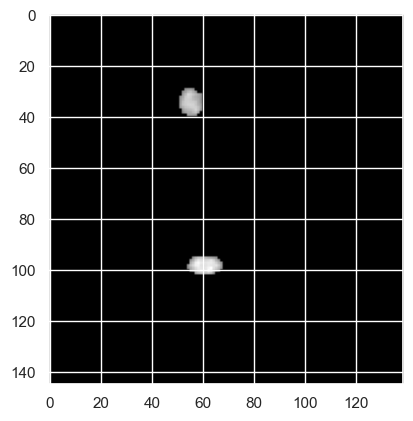

In [5]:
i = 14

print(train_data['Image_Path'][i])
image = rgb2hsv(skimage.io.imread(train_data['Image_Path'][i]))
print(np.max(image))
result = ((image > 0.5)*image)[..., 1]
plt.imshow(result, 'gray')

In [6]:
tqdm.pandas()
train_data['image_arr'] = train_data['Image_Path'].progress_apply(lambda x: read_image(x))
val_data['image_arr']   = val_data['Image_Path'].progress_apply(lambda x: read_image(x))
test_data['image_arr']  = test_data['Image_Path'].progress_apply(lambda x: read_image(x))


x_train, y_train = train_data['image_arr'].to_numpy(), train_data['Parasitized'].to_numpy()
x_val  , y_val   = val_data['image_arr'].to_numpy()  , val_data['Parasitized'].to_numpy()
x_test , y_test  = test_data['image_arr'].to_numpy() , test_data['Parasitized'].to_numpy()

100%|██████████| 2617/2617 [00:02<00:00, 1218.91it/s]


## Data Augmentation

In [7]:
import albumentations as A
import cv2

In [8]:
augment = A.augmentations.geometric.transforms.Affine(
    translate_percent = 0.1,
    rotate = 60,
    shear = 30
    )

augment = A.ShiftScaleRotate(scale_limit = (-0.5, 0.01),rotate_limit= 180, border_mode=cv2.BORDER_CONSTANT, always_apply= True)

transform = A.Compose(
    [augment,
    A.VerticalFlip(p = 0.5),
    A.HorizontalFlip(p = 0.5),
    A.augmentations.geometric.Affine(shear = 30),
    A.Resize(HEIGHT, WIDTH, always_apply= True)
    ]
)

aug_dataset = []
aug_labels = []
COPIES = 3

for i, lab in tqdm(zip(x_train, y_train)):
    for _ in range(COPIES):
        aug_dataset.append(transform(image = i)['image'])
        aug_labels.append(lab)

20601it [00:21, 946.82it/s]


In [9]:
x_train_aug = np.array(aug_dataset)
y_train_aug = np.array(aug_labels)

### Resizing

In [10]:
temp = []
for img in tqdm(x_train):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_train = np.array(temp)


temp = []
for img in tqdm(x_val):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_val = np.array(temp)


temp = []
for img in tqdm(x_test):
    temp.append(resize(img, (HEIGHT, WIDTH)))
x_test = np.array(temp)

100%|██████████| 2617/2617 [00:02<00:00, 1131.18it/s]


## Saving Data

In [11]:
compressed_pickle("x_train_aug", x_train_aug)
compressed_pickle("y_train_aug", y_train_aug)
compressed_pickle("x_train", x_train)
compressed_pickle("y_train", y_train)
compressed_pickle("x_val", x_val)
compressed_pickle("y_val", y_val)
compressed_pickle("x_test", x_test)
compressed_pickle("y_test", y_test)

## Loading Data

In [12]:
x_train_aug = decompress_pickle(SAVE_DIR + 'x_train_aug.pbz2')
y_train_aug = decompress_pickle(SAVE_DIR + 'y_train_aug.pbz2')
x_train = decompress_pickle(SAVE_DIR + 'x_train.pbz2')
y_train = decompress_pickle(SAVE_DIR + 'y_train.pbz2')
x_val = decompress_pickle(SAVE_DIR + 'x_val.pbz2')
y_val = decompress_pickle(SAVE_DIR + 'y_val.pbz2')
x_test = decompress_pickle(SAVE_DIR + 'x_test.pbz2')
y_test = decompress_pickle(SAVE_DIR + 'y_test.pbz2')

print("augmented: ", x_train_aug.shape, y_train_aug.shape)
print("train: ", x_train.shape, y_train.shape)
print("val: ", x_val.shape, y_val.shape)
print("test: ", x_test.shape, y_test.shape)

augmented:  (61803, 25, 25, 3) (61803,)
train:  (20601, 25, 25, 3) (20601,)
val:  (2943, 25, 25, 3) (2943,)
test:  (2617, 25, 25, 3) (2617,)


In [13]:
n_aug_train = x_train_aug.shape[0]
n_train     = x_train.shape[0]
n_val       = x_val.shape[0]
n_test      = x_test.shape[0]

## Modeling

In [14]:
N_DIGITS = 3

### Unaugmented

#### Naive Bayes

In [15]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = nb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.611     0.746     0.672     10260
         1.0      0.677     0.530     0.594     10341

    accuracy                          0.637     20601
   macro avg      0.644     0.638     0.633     20601
weighted avg      0.644     0.637     0.633     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.620     0.761     0.683      1466
         1.0      0.693     0.538     0.606      1477

    accuracy                          0.649      2943
   macro avg      0.657     0.649     0.644      2943
weighted avg      0.657     0.649     0.644      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.613     0.766     0.681      1303
         1.0      0.692     0.521     0.595      1314

    accuracy                          0.643      2617
   macro avg      0.653

#### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  LogisticRegression(max_iter = 200, verbose = 10, n_jobs = -1, solver = 'saga')
logreg_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = logreg_cls.predict(x_train.reshape(n_train, -1))
preds_val   = logreg_cls.predict(x_val.reshape(n_val, -1))
preds_test  = logreg_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


max_iter reached after 43 seconds
Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.729     0.754     0.741     10260
         1.0      0.747     0.722     0.734     10341

    accuracy                          0.738     20601
   macro avg      0.738     0.738     0.738     20601
weighted avg      0.738     0.738     0.738     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.693     0.715     0.704      1466
         1.0      0.708     0.685     0.696      1477

    accuracy                          0.700      2943
   macro avg      0.700     0.700     0.700      2943
weighted avg      0.700     0.700     0.700      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.689     0.738     0.713      1303
         1.0      0.721     0.670     0.694      1314

    accuracy                          0.704

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   42.9s finished


#### Decision Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 5, min_samples_split = 2, )
dt_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = dt_cls.predict(x_train.reshape(n_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.685     0.774     0.727     10260
         1.0      0.743     0.646     0.691     10341

    accuracy                          0.710     20601
   macro avg      0.714     0.710     0.709     20601
weighted avg      0.714     0.710     0.709     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.677     0.774     0.722      1466
         1.0      0.738     0.633     0.681      1477

    accuracy                          0.703      2943
   macro avg      0.707     0.703     0.702      2943
weighted avg      0.707     0.703     0.702      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.661     0.748     0.702      1303
         1.0      0.713     0.620     0.663      1314

    accuracy                          0.684      2617
   macro avg      0.687

#### XGBoost

In [18]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 5, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = xgb_cls.predict(x_train.reshape(n_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.966     0.983     0.974     10260
         1.0      0.983     0.966     0.974     10341

    accuracy                          0.974     20601
   macro avg      0.974     0.974     0.974     20601
weighted avg      0.975     0.974     0.974     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.842     0.873     0.857      1466
         1.0      0.869     0.837     0.853      1477

    accuracy                          0.855      2943
   macro avg      0.855     0.855     0.855      2943
weighted avg      0.855     0.855     0.855      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.842     0.861     0.851      1303
         1.0      0.859     0.839     0.849      1314

    accuracy                          0.850      2617
   macro avg      0.850

#### SVM

In [19]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'rbf', max_iter = 250, verbose= True)
svm_cls.fit(x_train.reshape(n_train, -1), y_train)
preds_train = svm_cls.predict(x_train.reshape(n_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.456     0.498     0.476     10260
         1.0      0.452     0.411     0.430     10341

    accuracy                          0.454     20601
   macro avg      0.454     0.454     0.453     20601
weighted avg      0.454     0.454     0.453     20601


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.446     0.477     0.461      1466
         1.0      0.442     0.412     0.426      1477

    accuracy                          0.444      2943
   macro avg      0.444     0.444     0.444      2943
weighted avg      0.444     0.444     0.444      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.457     0.486     0.471      1303
         1.0      0.456     0.428     0.441      1314

    accuracy                          0.457      2617
   macro avg      0.457

#### Transfer Learning

In [20]:
imagenet = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (72, 72, 3)
)
imagenet.trainable = False

trans_learn = tf.keras.Sequential([
    tf.keras.layers.Resizing(72, 72),
    imagenet,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

trans_learn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = trans_learn.fit(
            x_train, y_train, batch_size = 64,
            shuffle = True,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 32,
            callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
        )
preds_train = np.argmax(trans_learn.predict(x_train), axis = 1)
preds_val   = np.argmax(trans_learn.predict(x_val), axis = 1)
preds_test  = np.argmax(trans_learn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))



Epoch 1/50
322/322 [==============================] - 9s 17ms/step - loss: 0.2166 - accuracy: 0.9174 - val_loss: 0.1312 - val_accuracy: 0.9521
Epoch 2/50
322/322 [==============================] - 5s 15ms/step - loss: 0.1290 - accuracy: 0.9501 - val_loss: 0.1222 - val_accuracy: 0.9524
Epoch 3/50
322/322 [==============================] - 5s 15ms/step - loss: 0.1127 - accuracy: 0.9562 - val_loss: 0.1166 - val_accuracy: 0.9602
Epoch 4/50
322/322 [==============================] - 5s 15ms/step - loss: 0.1048 - accuracy: 0.9585 - val_loss: 0.1190 - val_accuracy: 0.9562
Epoch 5/50
322/322 [==============================] - 5s 15ms/step - loss: 0.0942 - accuracy: 0.9632 - val_loss: 0.1140 - val_accuracy: 0.9572
Epoch 6/50
322/322 [==============================] - 5s 15ms/step - loss: 0.0860 - accuracy: 0.9660 - val_loss: 0.1030 - val_accuracy: 0.9640
Epoch 7/50
322/322 [==============================] - 5s 15ms/step - loss: 0.0856 - accuracy: 0.9673 - val_loss: 0.1080 - val_accuracy: 0.9626

#### CNN Model

In [27]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = x_train[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train, y_train, batch_size = 1024,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 256,
            callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
        )
preds_train = np.argmax(cnn.predict(x_train), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Epoch 1/50
21/21 [==============================] - 1s 17ms/step - loss: 0.7031 - accuracy: 0.5248 - val_loss: 0.6811 - val_accuracy: 0.6174
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 0.6667 - accuracy: 0.6009 - val_loss: 0.6539 - val_accuracy: 0.6069
Epoch 3/50
21/21 [==============================] - 0s 8ms/step - loss: 0.6201 - accuracy: 0.6575 - val_loss: 0.6843 - val_accuracy: 0.5790
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 0.5892 - accuracy: 0.6901 - val_loss: 0.4957 - val_accuracy: 0.7788
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5119 - accuracy: 0.7567 - val_loss: 0.4690 - val_accuracy: 0.8029
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 0.4793 - accuracy: 0.7806 - val_loss: 0.4648 - val_accuracy: 0.7829
Epoch 7/50
21/21 [==============================] - 0s 7ms/step - loss: 0.4267 - accuracy: 0.8139 - val_loss: 0.3688 - val_accuracy: 0.8522
Epoch 8/50
21/21 [=

### Augmented Dataset

#### Naive Bayes

In [30]:
from sklearn import naive_bayes

nb_cls = naive_bayes.GaussianNB()
nb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = nb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = nb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = nb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.598     0.689     0.640     30780
         1.0      0.636     0.539     0.584     31023

    accuracy                          0.614     61803
   macro avg      0.617     0.614     0.612     61803
weighted avg      0.617     0.614     0.612     61803


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.571     0.003     0.005      1466
         1.0      0.502     0.998     0.668      1477

    accuracy                          0.502      2943
   macro avg      0.537     0.500     0.337      2943
weighted avg      0.537     0.502     0.338      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.750     0.002     0.005      1303
         1.0      0.502     0.999     0.669      1314

    accuracy                          0.503      2617
   macro avg      0.626

#### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

logreg_cls =  LogisticRegression(max_iter = 200, verbose = 10, n_jobs = -1, solver = 'saga')
logreg_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = logreg_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = logreg_cls.predict(x_val.reshape(n_val, -1))
preds_test  = logreg_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


max_iter reached after 132 seconds


c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.2min finished


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.669     0.740     0.703     30780
         1.0      0.712     0.636     0.672     31023

    accuracy                          0.688     61803
   macro avg      0.690     0.688     0.687     61803
weighted avg      0.690     0.688     0.687     61803


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.677     0.641     0.659      1466
         1.0      0.662     0.697     0.679      1477

    accuracy                          0.669      2943
   macro avg      0.669     0.669     0.669      2943
weighted avg      0.669     0.669     0.669      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.677     0.617     0.646      1303
         1.0      0.651     0.708     0.678      1314

    accuracy                          0.663      2617
   macro avg      0.664

#### Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_cls =  DecisionTreeClassifier(criterion = 'gini', splitter = 'best', max_depth = 20, min_samples_split = 2, )
dt_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = dt_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = dt_cls.predict(x_val.reshape(n_val, -1))
preds_test  = dt_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

# eval = testing_module.ModelEvaluation(y_val, 
#     nb_cls.predict(x_val.reshape(n_val, -1)),
#     model_reference_name = 'Naive Bayes',
#     model_type = 'classification',
#     plot_classification_metric = ['roc_auc']) # if classification
# eval.evaluate(evaluate_save= True, plots_show = True)

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.669     0.763     0.713     30780
         1.0      0.727     0.625     0.672     31023

    accuracy                          0.694     61803
   macro avg      0.698     0.694     0.692     61803
weighted avg      0.698     0.694     0.692     61803


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1466
         1.0      0.502     1.000     0.668      1477

    accuracy                          0.502      2943
   macro avg      0.251     0.500     0.334      2943
weighted avg      0.252     0.502     0.335      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1303
         1.0      0.502     1.000     0.669      1314

    accuracy                          0.502      2617
   macro avg      0.251

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m

#### XGBoost

In [36]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier(max_depth = 5, objective = 'reg:logistic',
                            num_parallel_tree = 20, booster = 'gbtree',
                            gamma = 0.5, tree_method = 'gpu_hist', subsample = 0.4, reg_lambda = 1)
xgb_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = xgb_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = xgb_cls.predict(x_val.reshape(n_val, -1))
preds_test  = xgb_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.836     0.904     0.869     30780
         1.0      0.897     0.824     0.859     31023

    accuracy                          0.864     61803
   macro avg      0.866     0.864     0.864     61803
weighted avg      0.867     0.864     0.864     61803


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1466
         1.0      0.502     1.000     0.668      1477

    accuracy                          0.502      2943
   macro avg      0.251     0.500     0.334      2943
weighted avg      0.252     0.502     0.335      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1303
         1.0      0.502     1.000     0.669      1314

    accuracy                          0.502      2617
   macro avg      0.251

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m

#### SVM

In [34]:
from sklearn.svm import SVC

svm_cls = SVC(kernel = 'rbf', max_iter = 250, verbose= True)
svm_cls.fit(x_train_aug.reshape(n_aug_train, -1), y_train_aug)
preds_train = svm_cls.predict(x_train_aug.reshape(n_aug_train, -1))
preds_val   = svm_cls.predict(x_val.reshape(n_val, -1))
preds_test  = svm_cls.predict(x_test.reshape(n_test, -1))

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))
                  

[LibSVM]

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Classification Report: 
               precision    recall  f1-score   support

         0.0      0.508     0.633     0.564     30780
         1.0      0.518     0.392     0.446     31023

    accuracy                          0.512     61803
   macro avg      0.513     0.512     0.505     61803
weighted avg      0.513     0.512     0.505     61803


Validation Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1466
         1.0      0.502     1.000     0.668      1477

    accuracy                          0.502      2943
   macro avg      0.251     0.500     0.334      2943
weighted avg      0.252     0.502     0.335      2943


Testing Classification Report: 
               precision    recall  f1-score   support

         0.0      0.000     0.000     0.000      1303
         1.0      0.502     1.000     0.669      1314

    accuracy                          0.502      2617
   macro avg      0.251

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m

#### Transfer Learning

In [40]:
imagenet = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (72, 72, 3)
)
imagenet.trainable = False

trans_learn = tf.keras.Sequential([
    tf.keras.layers.Resizing(72, 72),
    imagenet,

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

trans_learn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = trans_learn.fit(
            x_train_aug, y_train_aug, batch_size = 128,
            shuffle = True,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 64,
            callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
        )
preds_train = np.argmax(trans_learn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(trans_learn.predict(x_val), axis = 1)
preds_test  = np.argmax(trans_learn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))



Epoch 1/50
483/483 [==============================] - 14s 25ms/step - loss: 0.6566 - accuracy: 0.6789 - val_loss: 0.6932 - val_accuracy: 0.5019
Epoch 2/50
181/483 [==========>...................] - ETA: 6s - loss: 0.5643 - accuracy: 0.7162

KeyboardInterrupt: 

#### CNN Model

In [45]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu', input_shape = x_train_aug[0].shape),
    tf.keras.layers.MaxPool2D((3,3), padding = 'same'),

    tf.keras.layers.Conv2D(32, (2,2), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D((2,2), padding = 'same'),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

cnn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = cnn.fit(
            x_train_aug, y_train_aug, batch_size = 128,
            epochs = 50,
            validation_data = [x_val, y_val],
            validation_batch_size = 128,
            callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
        )
preds_train = np.argmax(cnn.predict(x_train_aug), axis = 1)
preds_val   = np.argmax(cnn.predict(x_val), axis = 1)
preds_test  = np.argmax(cnn.predict(x_test), axis = 1)

print("Training Classification Report: \n", classification_report(y_train_aug, preds_train, digits = N_DIGITS))
print("\nValidation Classification Report: \n", classification_report(y_val, preds_val, digits = N_DIGITS))
print("\nTesting Classification Report: \n", classification_report(y_test, preds_test, digits = N_DIGITS))

Epoch 1/50
483/483 [==============================] - 2s 4ms/step - loss: 14.9663 - accuracy: 0.4975 - val_loss: 0.6944 - val_accuracy: 0.4985
Epoch 2/50
483/483 [==============================] - 1s 3ms/step - loss: 9.4884 - accuracy: 0.5037 - val_loss: 0.6929 - val_accuracy: 0.5032
Epoch 3/50
483/483 [==============================] - 1s 3ms/step - loss: 6.5789 - accuracy: 0.5108 - val_loss: 0.6923 - val_accuracy: 0.5076
Epoch 4/50
483/483 [==============================] - 1s 3ms/step - loss: 4.8447 - accuracy: 0.5147 - val_loss: 0.6922 - val_accuracy: 0.5059
Epoch 5/50
483/483 [==============================] - 1s 3ms/step - loss: 3.6937 - accuracy: 0.5224 - val_loss: 0.6923 - val_accuracy: 0.4981
Epoch 6/50
483/483 [==============================] - 1s 3ms/step - loss: 2.8900 - accuracy: 0.5232 - val_loss: 0.6926 - val_accuracy: 0.4988
Epoch 7/50
82/82 [==============================] - 0s 1ms/step
Training Classification Report: 
               precision    recall  f1-score   sup

c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\m